# Tests and implementation for the RFClassifier class.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from estimator import RFClassifier, classical_weights, V1_inspired_weights, haltere_inspired_weights

## Implementation for V1 weights

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data, labels = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
# select the linear classifier
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(solver='saga')

# non-linearity
relu = lambda x: np.maximum(0, x)

# classify using classical weights
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(width=40, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

# classify using V1 weights
kwargs = {'t': 5, 'l': 3}
params_neural = {'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity':relu, 'clf': logit}
clf = RFClassifier(width=40, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

## Implementation for haltere weights

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data, labels = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
# linear classifier
logit = LogisticRegression(solver='saga')

# non-linearity
cos = lambda x: np.cos(x)
relu = lambda x: np.maximum(x, 0)

# params
params_classical = {'weight_fun': classical_weights, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_classical)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_classical = clf.W_[0]

kwargs = {'lowcut': 4, 'highcut': 6}
params_neural = {'weight_fun': haltere_inspired_weights, 'kwargs': kwargs, 'bias': b, 'nonlinearity': relu, 'clf': logit}
clf = RFClassifier(60, **params_neural)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
W_neural = clf.W_[0]

fig = plt.figure()
plt.plot(W_classical, c='k')
plt.plot(W_neural)

### Test the parallelized function for RFClassifer

In [ ]:
from estimator import RFClassifier, classical_weights, relu, haltere_inspired_weights, V1_inspired_weights, clf_wrapper
from data_fns import load_mnist
from sklearn.linear_model import SGDClassifier
import numpy as np
import numpy.linalg as la

In [ ]:
# use dask
import dask
from dask.distributed import Client
client = Client(threads_per_worker=5, n_workers=5)

In [ ]:
X_train, y_train, X_test, y_test = load_mnist('data/mnist/')
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
%%time
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-4, n_iter_no_change=10, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
train_err, test_err, clf = clf_wrapper(RFClassifier, params, X_train, y_train, X_test, y_test, return_clf=True)
print(test_err)

In [ ]:
%%time
from estimator import parallelized_clf
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-5, n_iter_no_change=30, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
mean_train_err, std_train_err, mean_test_err, std_test_err = parallelized_clf(RFClassifier, params, X_train, y_train,
                                                                             X_test, y_test, n_iters=5, 
                                                                              return_clf=False)

### test of fashion-mnist real quick

In [ ]:
from data_fns import load_fashion_mnist
X_train, y_train, X_test, y_test = load_mnist('data/fashion_mnist/')
b = np.mean(la.norm(X_train, axis=1) ** 2 / X_train.shape[1])

In [ ]:
%%time
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-4, n_iter_no_change=10, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
train_err, test_err, clf = clf_wrapper(RFClassifier, params, X_train, y_train, X_test, y_test, return_clf=True)
print(test_err)

In [ ]:
%%time
from estimator import parallelized_clf
sgd = SGDClassifier(loss='squared_hinge', alpha=1, shuffle=True, n_jobs=5, learning_rate='optimal', max_iter=500,
                       early_stopping=True, tol=1e-5, n_iter_no_change=30, validation_fraction=0.1)
kwargs = {'t': 5, 'l': 3}
params = {'width': 1000, 'weight_fun': V1_inspired_weights, 'kwargs': kwargs, 'bias': b, 
'nonlinearity': relu, 'clf': sgd}
mean_train_err, std_train_err, mean_test_err, std_test_err = parallelized_clf(RFClassifier, params, X_train, y_train,
                                                                             X_test, y_test, n_iters=5, 
                                                                              return_clf=False)

## Plot the histogram of norm He weights vs classical weights

In [1]:
import numpy as np
import numpy.linalg as la
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from estimator import classical_weights, V1_inspired_weights

In [2]:
h, d, scale = 500, 784, 1
W_He = nn.Linear(d, h)
nn.init.kaiming_normal_(W_He.weight)
W_He_norm = torch.norm(W_He.weight, dim=1).detach().numpy()
print(np.mean(W_He_norm))

1.4140801


In [3]:
W_RF = classical_weights(h, d, scale=2/d)
W_RF_norm = la.norm(W_RF, axis=1)
print(np.mean(W_RF_norm))

1.4143884264478257


In [4]:
W_V1 = V1_inspired_weights(h, d, t=5, l=3, scale=2/d)
W_V1_norm = la.norm(W_V1, axis=1)
print(np.mean(W_V1_norm))

1.3598855474425509


(array([  5.,  24.,  71., 132., 138.,  93.,  31.,   4.,   1.,   1.]),
 array([1.3056203, 1.3318558, 1.3580914, 1.3843268, 1.4105623, 1.4367979,
        1.4630333, 1.4892688, 1.5155042, 1.5417398, 1.5679753],
       dtype=float32),
 <a list of 10 Patch objects>)

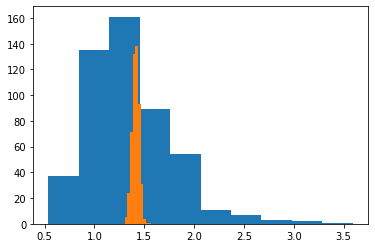

In [5]:
fig = plt.figure()
plt.hist(W_V1_norm)
# plt.hist(W_RF_norm)
plt.hist(W_He_norm)

In [41]:
W_He_norm

array([1.4290055, 1.3860724, 1.4096954, 1.494191 , 1.4119589, 1.424354 ,
       1.3108749, 1.4185705, 1.4348987, 1.4841726, 1.4085414, 1.4260665,
       1.3585726, 1.4409862, 1.3882544, 1.3766495, 1.4241916, 1.420901 ,
       1.4295037, 1.4396697, 1.374025 , 1.413592 , 1.4339856, 1.4995008,
       1.3470186, 1.4496988, 1.3827734, 1.3753494, 1.4292448, 1.4816735,
       1.4212319, 1.3822292, 1.3692741, 1.384284 , 1.3851255, 1.4132826,
       1.3888563, 1.342924 , 1.3837602, 1.3491008, 1.3268031, 1.4046246,
       1.3976828, 1.4525076, 1.3634299, 1.4476266, 1.4004169, 1.3901961,
       1.455722 , 1.4099157, 1.4181848, 1.4100642, 1.4331874, 1.393956 ,
       1.4655448, 1.409786 , 1.4467102, 1.4018979, 1.4362329, 1.3726166,
       1.3677443, 1.434094 , 1.3874334, 1.3871925, 1.404322 , 1.3783853,
       1.3799696, 1.3921349, 1.446489 , 1.4335761, 1.3738235, 1.4293773,
       1.4236538, 1.4300106, 1.433518 , 1.3946348, 1.4547588, 1.3309562,
       1.4279922, 1.3917665, 1.3908951, 1.401768 , 